# Лабораторная работа №3. Синтез БИХ-фильтров




In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal
import matplotlib.ticker as ticker
import time

## Модуль 1. Метод размещения нулей и полюсов.


### Задача 1.1 Синтез цифрового резонатора

| Варианты: |   $1$ |    $2$ |    $3$ |    $4$ |    $5$ |    $6$ | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|
|  $\nu_0$  | $0.25$ | $0.2$ | $0.1$ |  $—$ | $—$ | $—$ |
|$\theta_0$ | $—$ | $—$ | $—$ | $\dfrac\pi6$ | $\dfrac\pi3$ | $\dfrac\pi2$ |

Синтезировать методом размещения нулей и полюсов цифровой резонатор для частоты $\nu_0$ или $\theta_0$ (в зависимости от варианта). Параметр, влияющий на добротность резонатора, подобрать самостоятельно.

* Построить нуль-полюсную диаграмму получившегося фильтра.
* Записать передаточную функцию $H(z)$.
* Вычислить аналитически импульсную и переходную характеристики и сравнить с результатами моделирования.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.

In [51]:
# For variant 1
nu_0 = 0.25
theta = 2 * np.pi * nu_0
a = 0.85 # добротность

In [52]:
zeros = np.array((-1, 1))
poles = np.array((a*np.exp(1j*theta), a*np.exp(-1j*theta)))
G0 = (1 - a) * np.sqrt(1 + a**2 - 2*a*np.cos(2*theta)) / (2*abs(np.sin(theta)))

system = signal.dlti(zeros, poles, G0, dt=1)
w, H = signal.dfreqresp(system, w=np.linspace(-np.pi, np.pi, 1024))

In [53]:
def dumpZerosPolesDiagram(zeros, poles):
    q = np.linspace(0, 2*np.pi, 401)
    fig = plt.figure(figsize=[6, 6])
    fig.patch.set_facecolor('white')
    plt.plot(np.cos(q), np.sin(q), 'k--')  
    plt.plot(zeros.real, zeros.imag, 'ro', markersize=10, label='Нули')
    plt.plot(poles.real, poles.imag, 'bx', markersize=10, label='Полюса')
    plt.grid()
    plt.axis('image')
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, numpoints=1)
    plt.title("Нуль-полюсная диаграмма")
    plt.xlabel("Re $z$")
    plt.ylabel("Im $z$")
    plt.show()

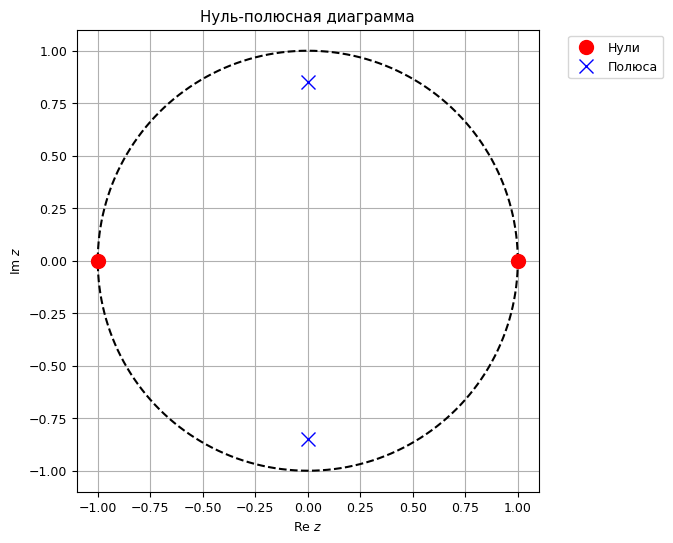

In [54]:
dumpZerosPolesDiagram(zeros, poles)

In [55]:
def Hz(z, zs, ps, k):
    res = k
    for zero in zs:
        res *= (z-zero)
    for pole in ps:
        res /= (z-pole)
    return res

In [56]:
def plotHzPFlat(H_func):
    plt.rcParams.update({'font.size': 9})
    fig = plt.figure(figsize=[8, 8])
    fig.patch.set_facecolor('white')
    ax = plt.axes(projection='3d')
    Re=np.arange(-1.2, 1.2, 0.1)
    Im=np.arange(-1.2, 1.2, 0.1)
    Re, Im = np.meshgrid(Re, Im)
    Z1=(Re+1j*Im)
    Z=abs(H_func(Z1))
    Z=np.minimum(Z, 3*np.ones(Z.shape))

    phi=np.linspace(0, 2*np.pi, 500)
    #ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
    ax.plot_wireframe(Re, Im, Z, color='grey')

    for u in phi:
        Z1=np.exp(-1j*u)
        Z2=abs(H_func(Z1))
        ax.plot([Z1.real, Z1.real], [Z1.imag, Z1.imag], [0.0, Z2],  color=(abs(np.cos(u)), 0.7, 0.5))

    Z1=np.exp(-1j*phi)
    Z2=abs(H_func(Z1))

    ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color='b')

    ax.set_zlim(0,1.2)
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_zticks(np.linspace(0, 1.2, 5))
    ax.view_init(20, 50)
    ax.set_xlabel("Re $z$")
    ax.set_ylabel("Im $z$")

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("$|H(z)|$   ", rotation=0)
    plt.tight_layout()
#     plt.rcParams.update({'font.size': fontsize})

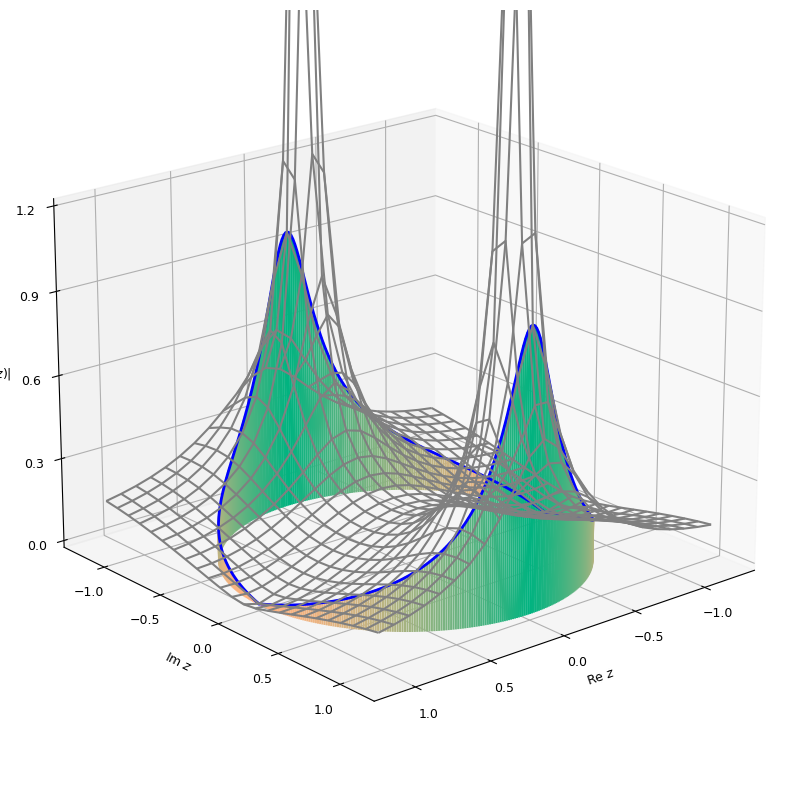

In [57]:
H_func = lambda z: Hz(z, zeros, poles, G0)
plotHzPFlat(H_func)

In [69]:
def plot_signal(h_analitic, h_calc, y_label="$h[k]$"):
    fig = plt.figure(figsize=(12,6))
    fig.patch.set_facecolor('white')

    plt.stem(t, h_analitic, linefmt='b', basefmt = 'k--', markerfmt = 'bo', label="$h_{an}[k]$")
    plt.stem(t, np.squeeze(h_calc), linefmt='r--', basefmt = 'k--', markerfmt = 'rx', label="$h[k]$")

    plt.xlim(-0.5, 25)
    plt.xlabel("$k$")
    plt.ylabel(y_label)
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

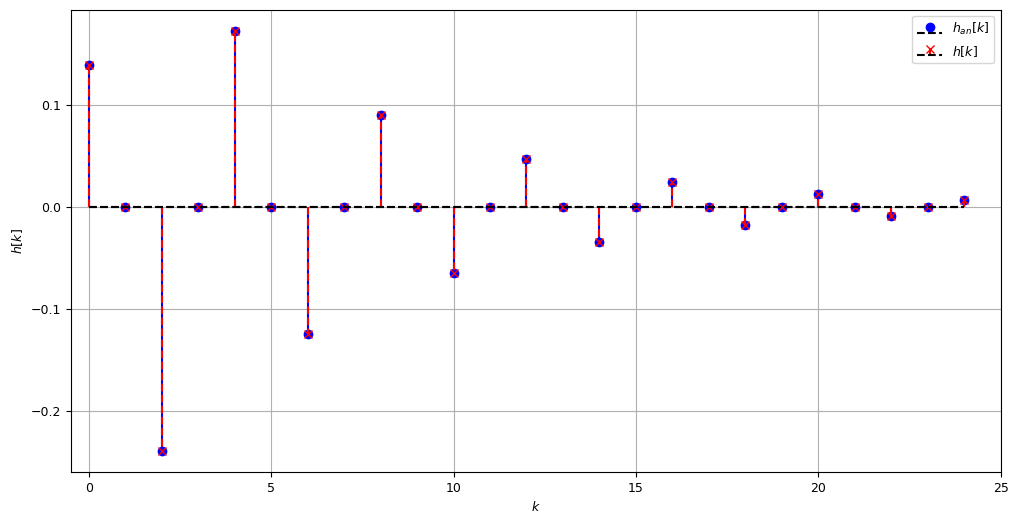

In [70]:
n = np.arange(25)
h_analitic = G0 * a**(n-2) * (a**2 * np.sin((n+1)*theta) - np.sin((n-1)*theta))/np.sin(theta)
h_analitic[0] += -G0/a**2

t, h_calc = signal.dimpulse(system, n=len(n))

plot_signal(h_analitic, h_calc)

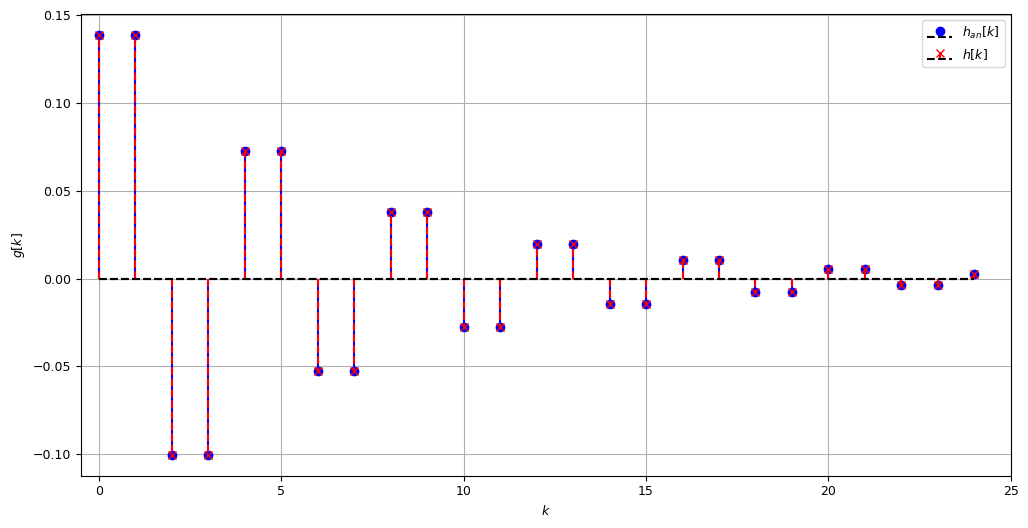

In [71]:
n = np.arange(25)
g_analitic = G0 * a**(n-1) * (a * np.sin((n+1)*theta) + np.sin(n*theta))/np.sin(theta)

t, g_calc = signal.dstep(system, n=len(n))

plot_signal(g_analitic, g_calc, "$g[k]$")

In [75]:
def plot_AFC(H_calc, H_analitic = np.array([])):
    fig = plt.figure(figsize=[10, 5])
    fig.patch.set_facecolor('white')
    plt.plot(w/(2*np.pi), abs(H_calc), lw=3, ls='-', color='y', label="scipy")
    if len(H_analitic) > 0:
        plt.plot(w/(2*np.pi), abs(H_analitic), lw=2.5, ls='--', color='g', label="handmade")
    plt.legend(loc='best')
    plt.xlabel("$\\nu$")
    plt.ylabel("$|H(\\nu)|$")
    plt.title("АЧХ фильтра")
    plt.xlim([-0.5, 0.5])
    plt.xticks(np.linspace(-0.5, 0.5, 11))
    plt.grid()
    plt.show()

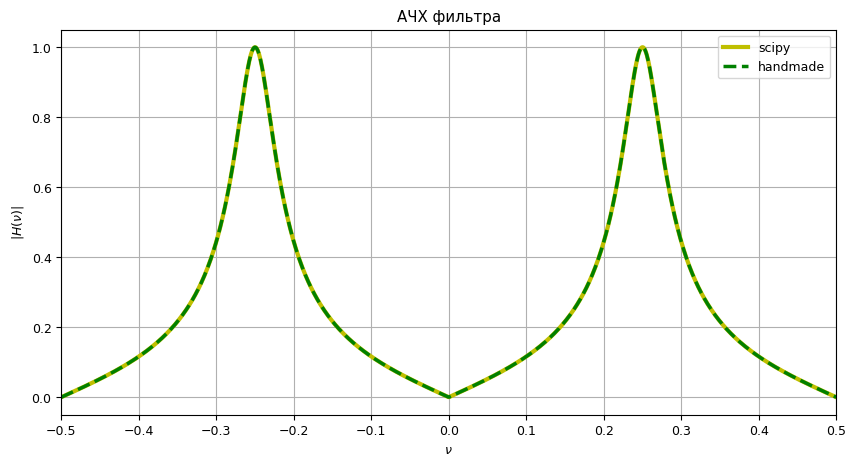

In [76]:
H_analitic = G0 * (1 - np.exp(-2*1j*w)) / (1 - 2*a*np.cos(theta)*np.exp(-1j*w) 
       + a**2 * np.exp(-2*1j*w))

plot_AFC(H, H_analitic)

In [77]:
def plot_PFC(H_calc, H_analitic = np.array([])):
    fig = plt.figure(figsize=[10, 5])
    fig.patch.set_facecolor('white')
    plt.plot(w/(2*np.pi), np.angle(H_calc), lw=3, ls='-', color='y', label="scipy")
    if len(H_analitic) > 0:
        plt.plot(w/(2*np.pi), np.angle(H_analitic), lw=2.5, ls='--', color='g', label="handmade")
    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel("$\\nu$")
    plt.ylabel("$\\arg\{H(\\nu)\}$")
    plt.title("ФЧХ фильтра")
    plt.xlim([-0.5, 0.5])
    plt.xticks(np.linspace(-0.5, 0.5, 11))
    plt.grid()
    plt.show()

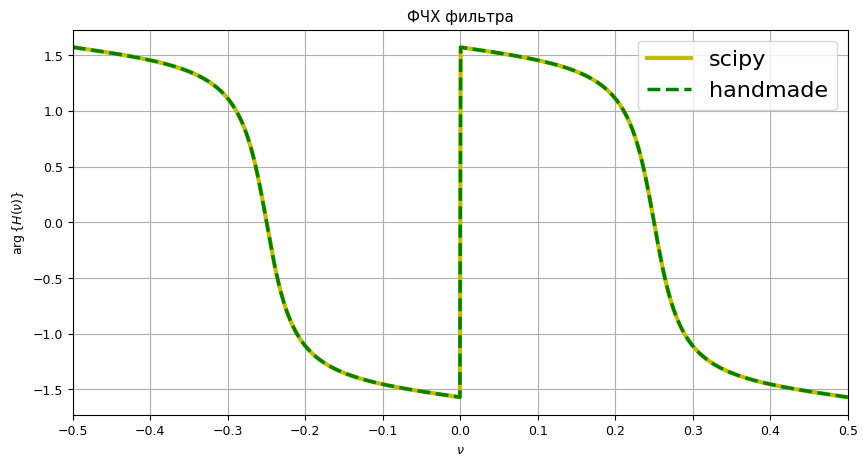

In [78]:
plot_PFC(H, H_analitic)

### Задача 1.2 Синтез цифрового фильтра Hum removal

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|
|  $f_0$, Гц  | 250 | 350 | 400 |  200 | 100 | 150 |
|  $f_д$, Гц | 1000 | 1000 | 1000 | 500 | 500 | 500 |

Синтезировать методом размещения нулей и полюсов цифровой фильтр Hum removal  для частоты $f_{0}$, $f_{д}$. Параметр, влияющий на добротность, подобрать самостоятельно.

* Записать передаточную функцию $H(z)$.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.


In [79]:
f0 = 250
fs = 1000
nu_0 = f0/fs
theta = 2 * np.pi * nu_0
a = 0.9

zeros = np.array((np.exp(1j*theta), np.exp(-1j*theta)))
poles = a * zeros
G0 = (1 - 2*a*np.cos(theta) + a**2) / (2*(1 - np.cos(theta)))

system = signal.dlti(zeros, poles, G0, dt=1)
w, H = signal.dfreqresp(system, w=np.linspace(-np.pi, np.pi, 1024))

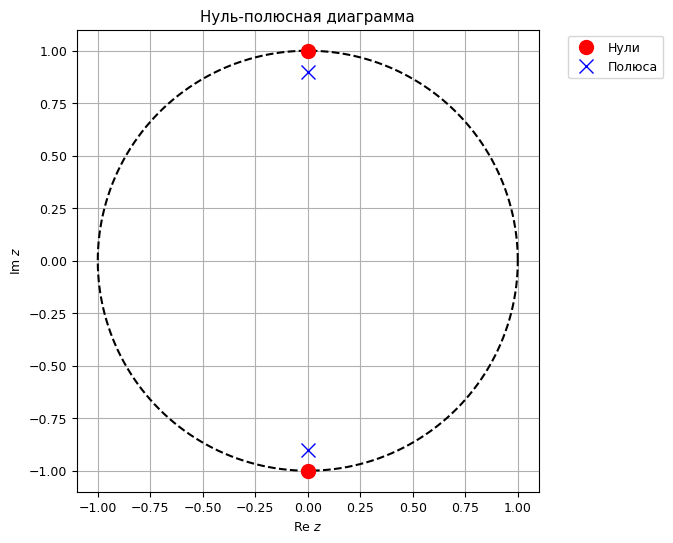

In [80]:
dumpZerosPolesDiagram(zeros, poles)

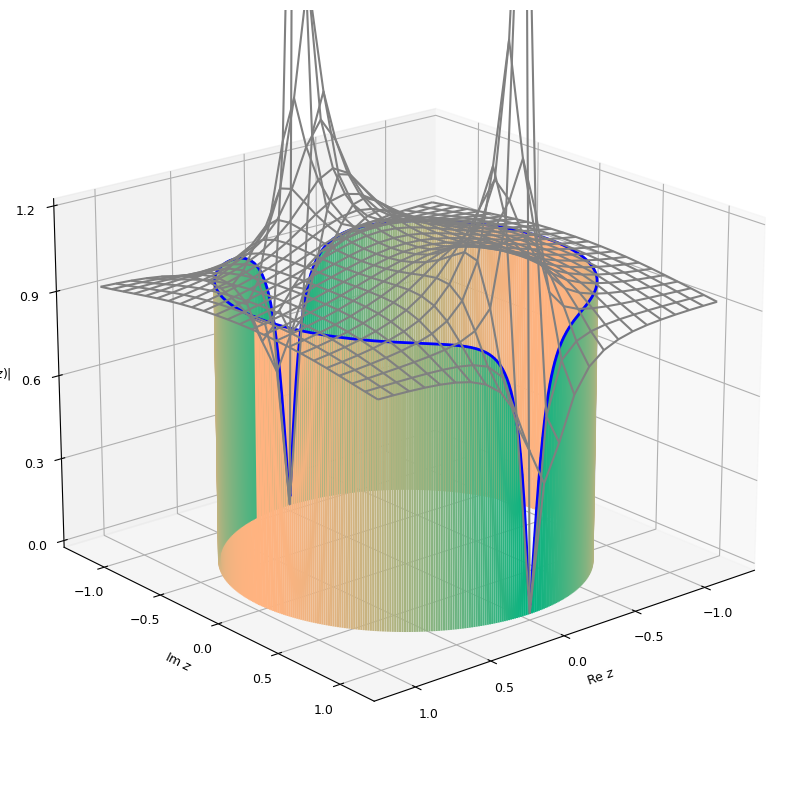

In [81]:
H_func = lambda z: Hz(z, zeros, poles, G0)
plotHzPFlat(H_func)

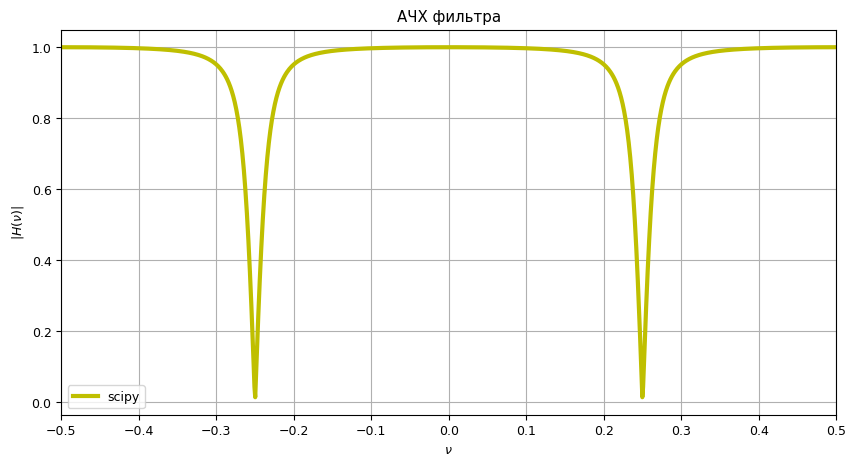

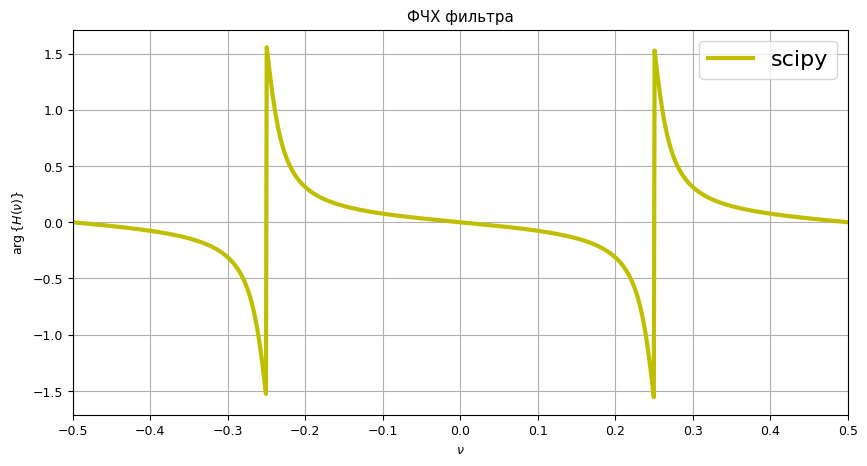

In [84]:
plot_AFC(H)
plot_PFC(H)

## Модуль 2. Метод билинейного *z*-преобразования

### Задача 2.1 Синтез фильтра нижних частот (ФНЧ)

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|
|  $f_д$, Гц  | 6000 | 6200 | 6400 |  6600 | 6800 | 7000 |
|  $f_1$, Гц | 800 | 860 | 920 | 980 | 1040 | 1100 |
|  $f_2$, Гц | 1100 | 1170 | 1240 | 1310 | 1380 | 1450 |
|  $a_\max$, дБ | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 |
|  $a_\min$, дБ | 40 | 40 | 40 | 40 | 40 | 40 |

 Получить коэффициенты разностного уравнения БИХ-фильтра нижних частот со следующими характеристиками:
* частота дискретизации $f_{д}$, 
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимальное допустимое затухание в полосе пропускания $a_\max$,
* минимальное допустимое затухание в полосе задерживания $a_\min$.

Воспользоваться методом билинейного z-преобразования для фильтров: 

1) Баттервота,

2) Чебышёва 1 рода,

3) Чебышёва 2 рода,

4) Золотарёва—Кауэра.

Из четырех получившихся результатов выбрать фильтр, обладающий наименьшим порядком $N$ и построить схему его реализации в виде каскада биквадратных блоков. Для биквадратных блоков выбрать прямую каноническую реализацию. 


In [85]:
fs = 6000
f1 = 800
f2 = 1100
a_max = 0.4455
delta1 = 1-10**(-a_max/20)
a_min = 40
delta2 = 10**(-a_min/20)
delta1, delta2

(0.04999694912604835, 0.01)

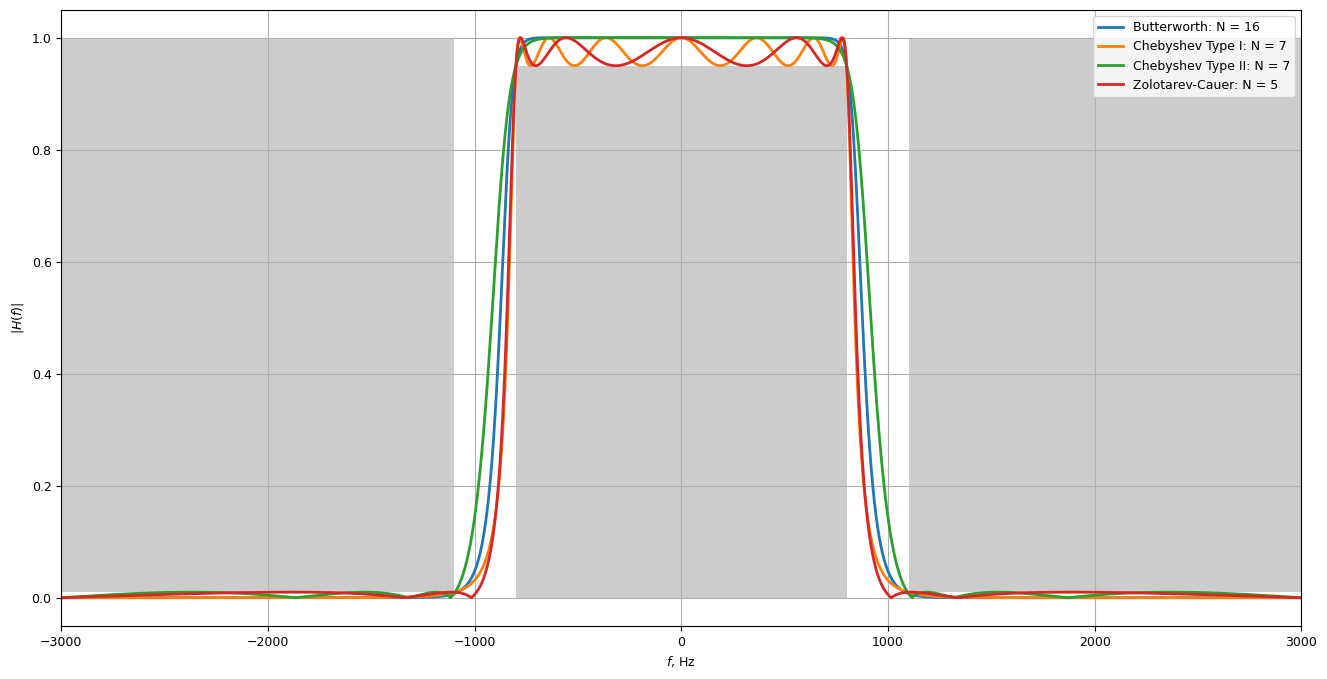

In [86]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')

N, Wn = signal.buttord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.butter(N, Wn=Wn, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, abs(H), lw = 2, label = f'Butterworth: N = {N}')

N, Wn = signal.cheb1ord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.cheby1(N, Wn=Wn, rp=a_max, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, abs(H), lw = 2, label = f'Chebyshev Type I: N = {N}')

N, Wn = signal.cheb2ord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.cheby2(N, Wn=Wn, rs=a_min, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, abs(H), lw = 2, label = f'Chebyshev Type II: N = {N}')

N, Wn = signal.ellipord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.ellip(N, Wn=Wn, rp=a_max, rs=a_min, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, abs(H), lw = 2, label = f'Zolotarev-Cauer: N = {N}')

plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$, Hz")
plt.ylabel("$|H(f)|$")
plt.fill([-f1,-f1, f1, f1], [0, 1-delta1, 1-delta1, 0], '0.8', lw=2)
plt.fill([-fs,-fs, -f2, -f2], [delta2, 1, 1, delta2], '0.8', lw=2)
plt.fill([fs, fs, f2, f2], [delta2, 1, 1, delta2], '0.8', lw=2)

plt.grid()
plt.legend(loc='upper right')
plt.show()

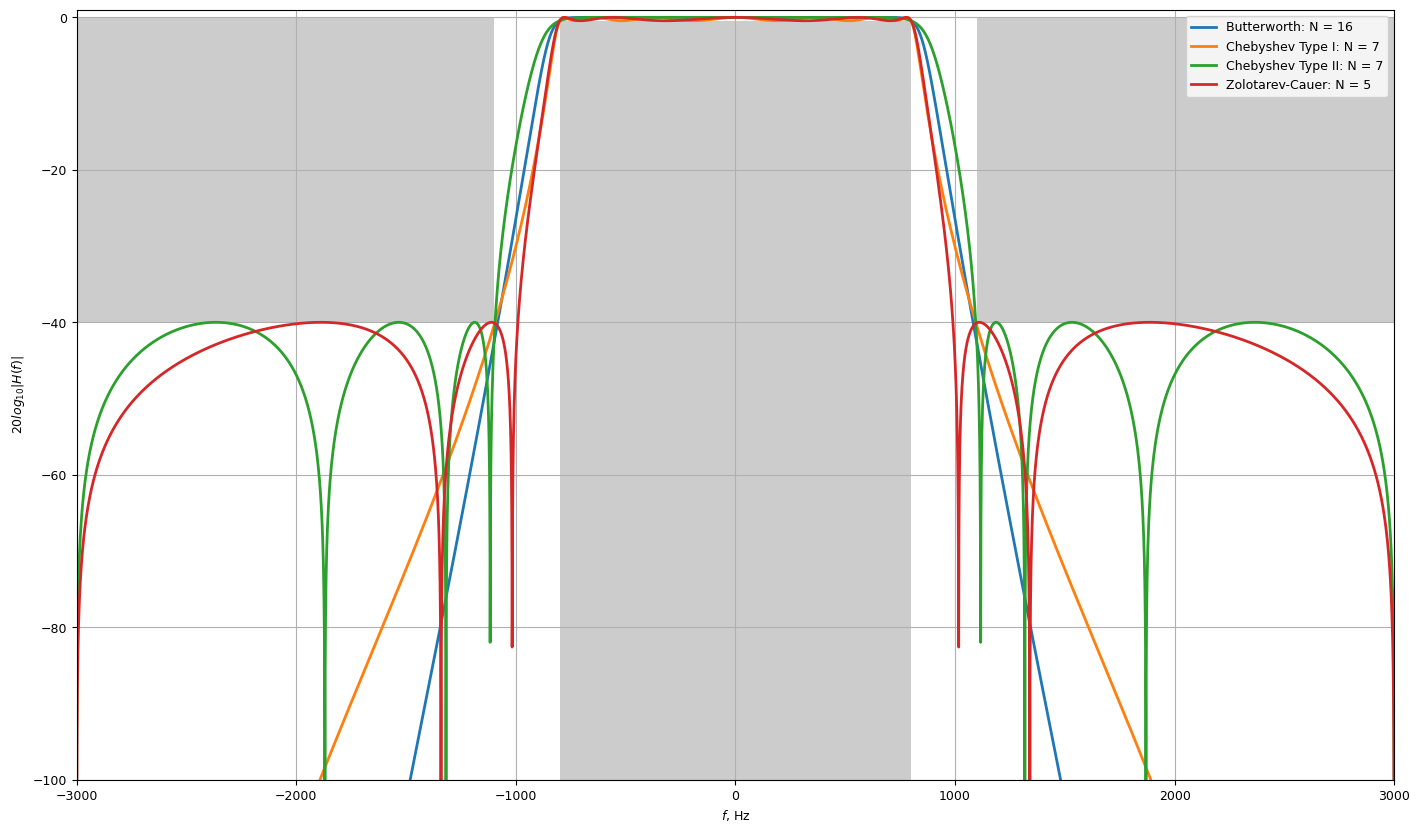

In [87]:
fig, ax = plt.subplots(figsize=(17, 10))
fig.patch.set_facecolor('white')

N, Wn = signal.buttord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.butter(N, Wn=Wn, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, 20*np.log10(abs(H)), lw = 2, label = f'Butterworth: N = {N}')

N, Wn = signal.cheb1ord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.cheby1(N, Wn=Wn, rp=a_max, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, 20*np.log10(abs(H)), lw = 2, label = f'Chebyshev Type I: N = {N}')

N, Wn = signal.cheb2ord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.cheby2(N, Wn=Wn, rs=a_min, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, 20*np.log10(abs(H)), lw = 2, label = f'Chebyshev Type II: N = {N}')

N, Wn = signal.ellipord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.ellip(N, Wn=Wn, rp=a_max, rs=a_min, btype='lowpass', analog=False, output='ba', fs=fs)
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 10000), fs=fs)
plt.plot(f, 20*np.log10(abs(H)), lw = 2, label = f'Zolotarev-Cauer: N = {N}')

plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$, Hz")
plt.ylabel("$20log_{10}|H(f)|$")

plt.fill([-f1,-f1, f1, f1], [-100, -a_max, -a_max, -100], '0.8', lw=2)
plt.fill([-fs,-fs, -f2, -f2], [-a_min, 0, 0, -a_min], '0.8', lw=2)
plt.fill([fs,fs, f2, f2], [-a_min, 0, 0, -a_min], '0.8', lw=2)
plt.ylim(-100, 1)

plt.grid()
plt.legend(loc='upper right')
plt.show()

In [88]:
N, Wn = signal.ellipord(wp=f1, ws=f2, gpass=a_max, gstop=a_min, analog=False, fs=fs)
beta, alpha = signal.ellip(N, Wn=Wn, rp=a_max, rs=a_min, btype='lowpass', analog=False, output='ba', fs=fs)
print(f'beta:{beta}')
print(f'alpha:{alpha}')
print(signal.tf2sos(beta, alpha))

beta:[ 0.02484758 -0.00749747  0.0253482   0.0253482  -0.00749747  0.02484758]
alpha:[ 1.         -3.16146297  4.74217079 -3.94523587  1.81859737 -0.36867272]
[[ 0.02484758  0.02484758  0.          1.         -0.6453319   0.        ]
 [ 1.         -0.33189444  1.          1.         -1.2609773   0.63254003]
 [ 1.         -0.96984403  1.          1.         -1.25515377  0.90317071]]


### Задача 2.2 Синтез аналога двухкаскадного RC-фильтра (I способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом билинейного *z*-преобразования.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

In [89]:
RC=2*1e-4
dt=RC/8
print(f'RC={RC}, dt={dt}, 1/dt={1/dt}')
num = [1] 
denom = [RC**2, 2*RC, 1]
LTI = signal.lti(num, denom)
LTI

RC=0.0002, dt=2.5e-05, 1/dt=40000.0


TransferFunctionContinuous(
array([25000000.]),
array([1.0e+00, 1.0e+04, 2.5e+07]),
dt: None
)

In [90]:
alpha = [1, 2, 1],
beta = [(2*RC/dt + 1)**2, (2 - 8*(RC/dt)**2), (2*RC/dt - 1)**2]
DLTI = signal.dlti(alpha, beta, dt=dt)
DLTI

TransferFunctionDiscrete(
array([0.00346021, 0.00692042, 0.00346021]),
array([ 1.        , -1.76470588,  0.77854671]),
dt: 2.5e-05
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_19080\3655481813.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(theta_d/(2*np.pi*dt), 20*np.log10(abs(H_d)), "r", lw=2, ls='--', label="$|H(f)|$")


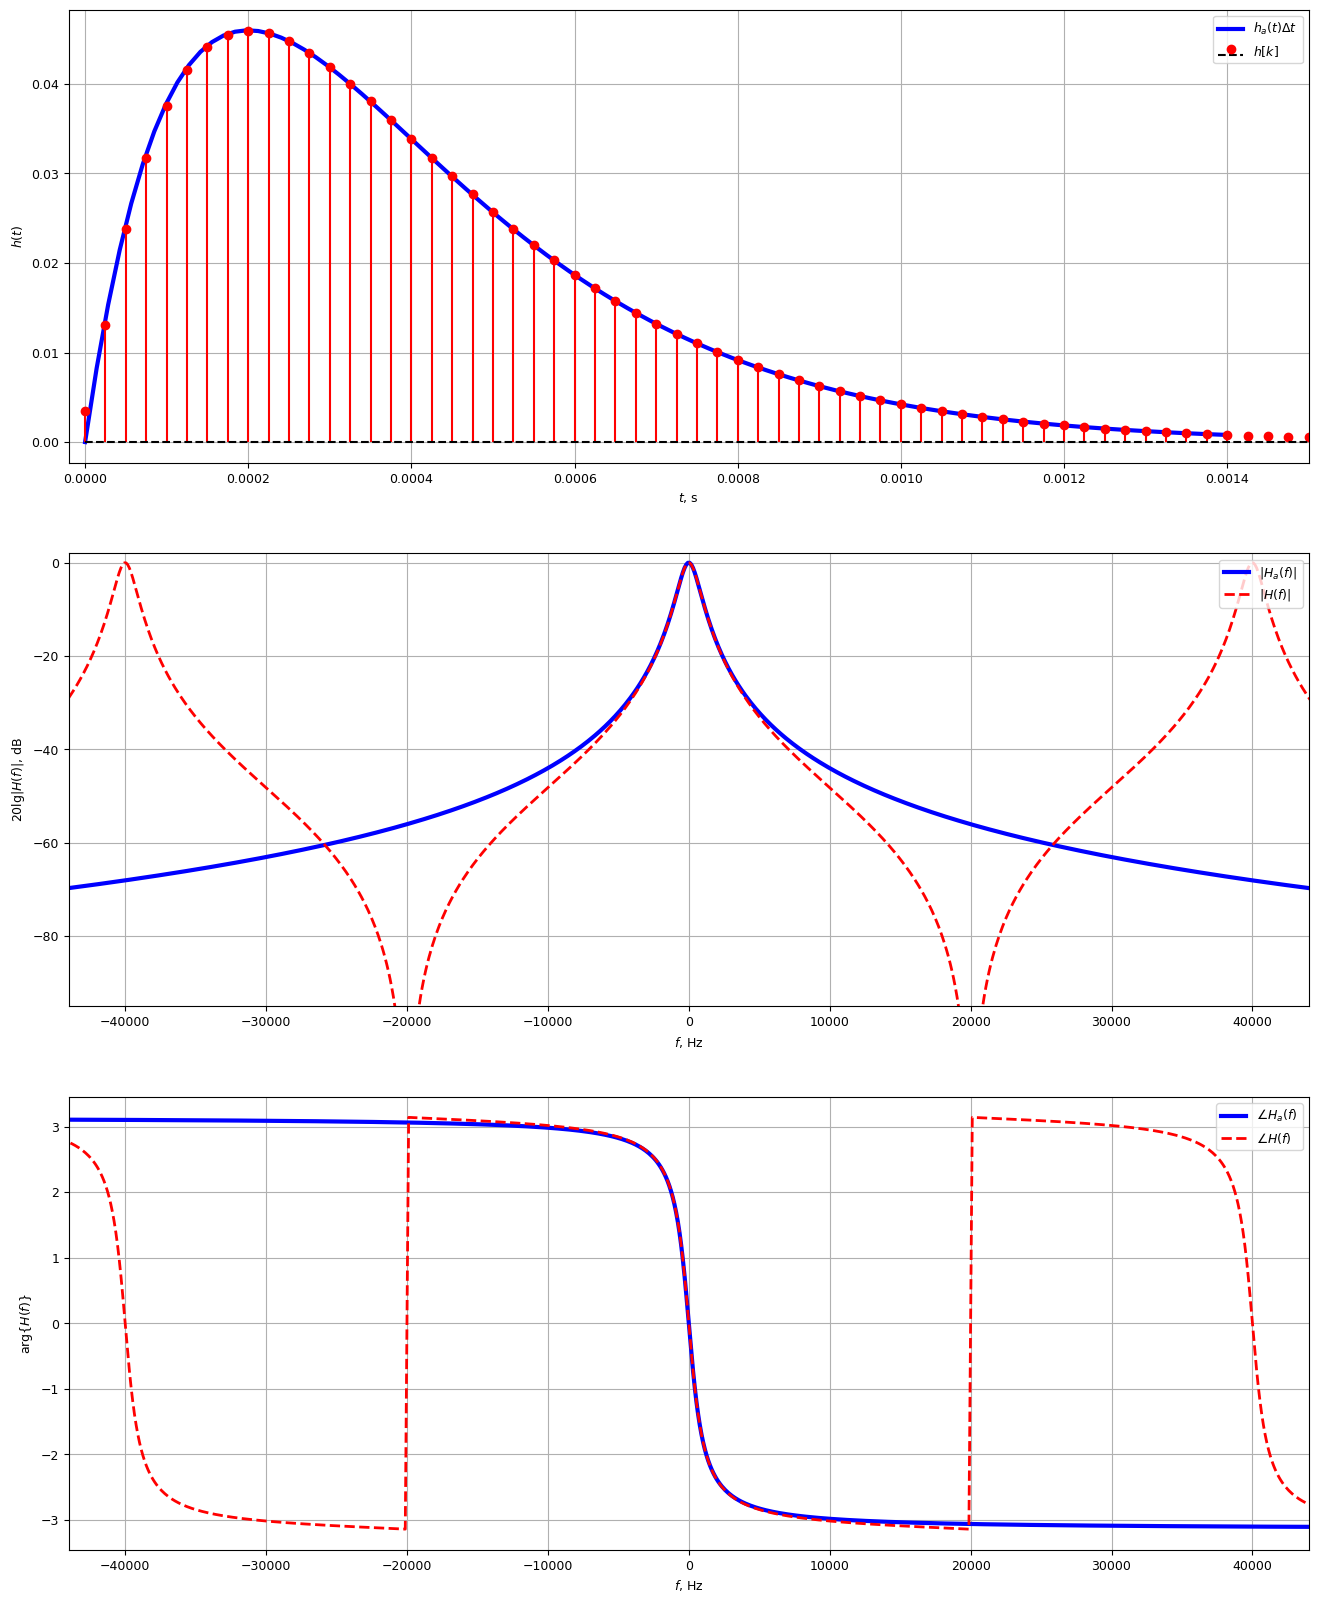

In [91]:
fig = plt.figure(figsize=(16,20))
fig.patch.set_facecolor('white')
#______________
plt.subplot(311)
t, h_a = signal.impulse(LTI)
plt.plot(t, h_a*dt, 'b', lw=3, label="$h_a(t) \\Delta t$")

t, h = signal.dimpulse(DLTI, n=100)
plt.stem(t, np.squeeze(h), linefmt='r', basefmt = 'k--', markerfmt = 'ro', label="$h[k]$")

plt.grid()
plt.xlim([-2e-5, 1.5e-3])
plt.xlabel("$t$, s")
plt.ylabel("$h(t)$")
plt.legend(loc = 'upper right')
#______________
plt.subplot(312)
w_a, H_a = signal.freqresp(LTI, w=np.linspace(-3*np.pi, 3*np.pi, 1000)/dt)
theta_d, H_d = signal.dfreqresp(DLTI, w=np.linspace(-3*np.pi, 3*np.pi, 1000))
plt.plot(w_a/(2*np.pi), 20*np.log10(abs(H_a)), "b", lw=3, label="$|H_a(f)|$")
plt.plot(theta_d/(2*np.pi*dt), 20*np.log10(abs(H_d)), "r", lw=2, ls='--', label="$|H(f)|$")
#plt.plot(w_a/(2*np.pi), abs(H_a), "b", lw=3, label="$|H_a(f)|$")
#plt.plot(theta_d/(2*np.pi*dt), abs(H_d), "r", lw=2, ls='--', label="$|H(f)|$")
plt.ylabel("$20 \lg |H(f)|$, dB")
plt.xlabel("$f$, Hz")
#plt.ylim(-0.01, 0.01)
plt.ylim(-95, 2)
plt.xlim(-1.1/dt, +1.1/dt)
plt.legend(loc = 'upper right')
plt.grid()
#______________
plt.subplot(313)
plt.plot(w_a/(2*np.pi), np.angle(H_a), "b", lw=3, label="$\\angle H_a(f)$")
plt.plot(theta_d/(2*np.pi*dt), np.angle(H_d), "r", lw=2, ls='--', label="$\\angle H(f)$")
plt.ylabel("arg$\{H(f)\}$")
plt.xlabel("$f$, Hz")
plt.xlim(-1.1/dt, +1.1/dt)
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

## Модуль 3. Метод инвариантной импульсной характеристики.

### Задача 3.1 Синтез аналога двухкаскадного RC-фильтра (II способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом инвариантной импульсной характеристики.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

In [92]:
# RC=2*1e-4
# dt=RC/8
print(f'RC={RC}, dt={dt}, 1/dt={1/dt}')
num = [1] 
denom = [RC**2, 2*RC, 1]
LTI = signal.lti(num, denom)
LTI

RC=0.0002, dt=2.5e-05, 1/dt=40000.0


TransferFunctionContinuous(
array([25000000.]),
array([1.0e+00, 1.0e+04, 2.5e+07]),
dt: None
)

In [93]:
A = dt/RC
alpha = [0, A**2*np.exp(-A), 0]
beta = [1,-2*np.exp(-A), np.exp(-2*A)]
DLTI = signal.dlti(alpha, beta, dt=dt)
DLTI

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


TransferFunctionDiscrete(
array([0.01378901, 0.        ]),
array([ 1.        , -1.76499381,  0.77880078]),
dt: 2.5e-05
)

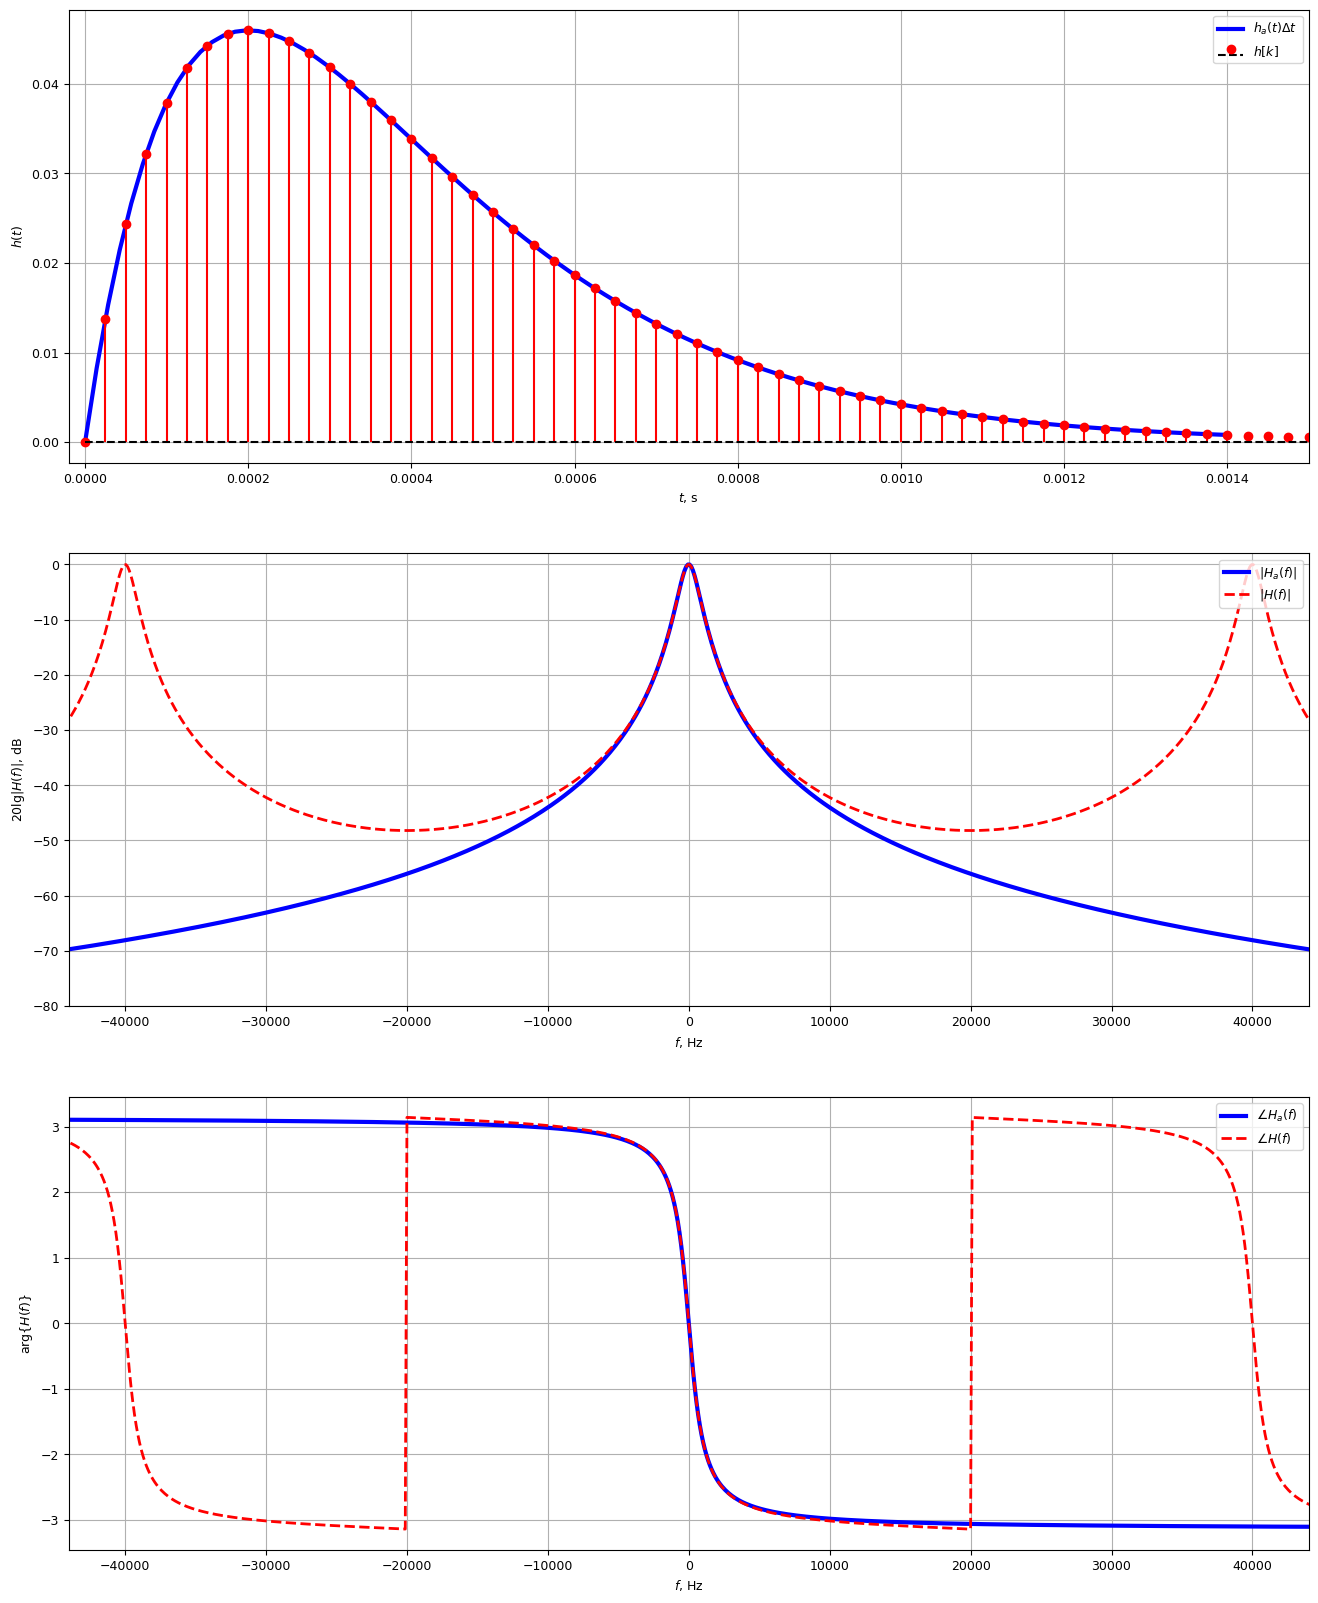

In [94]:
fig = plt.figure(figsize=(16,20))
fig.patch.set_facecolor('white')
#______________
plt.subplot(311)
t, h_a = signal.impulse(LTI)
plt.plot(t, h_a*dt, 'b', lw=3, label="$h_a(t) \\Delta t$")

t, h = signal.dimpulse(DLTI, n=100)
plt.stem(t, np.squeeze(h), linefmt='r', basefmt = 'k--', markerfmt = 'ro', label="$h[k]$")

plt.grid()
plt.xlim([-2e-5, 1.5e-3])
plt.xlabel("$t$, s")
plt.ylabel("$h(t)$")
plt.legend(loc = 'upper right')
#______________
plt.subplot(312)
w_a, H_a = signal.freqresp(LTI, w=np.linspace(-3*np.pi, 3*np.pi, 1000)/dt)
theta_d, H_d = signal.dfreqresp(DLTI, w=np.linspace(-3*np.pi, 3*np.pi, 1000))
plt.plot(w_a/(2*np.pi), 20*np.log10(abs(H_a)), "b", lw=3, label="$|H_a(f)|$")
plt.plot(theta_d/(2*np.pi*dt), 20*np.log10(abs(H_d)), "r", lw=2, ls='--', label="$|H(f)|$")
#plt.plot(w_a/(2*np.pi), abs(H_a), "b", lw=3, label="$|H_a(f)|$")
#plt.plot(theta_d/(2*np.pi*dt), abs(H_d), "r", lw=2, ls='--', label="$|H(f)|$")
plt.ylabel("$20 \lg |H(f)|$, dB")
plt.xlabel("$f$, Hz")
#plt.ylim(-0.01, 0.01)
plt.ylim(-80, 2)
plt.xlim(-1.1/dt, +1.1/dt)
plt.legend(loc = 'upper right')
plt.grid()
#______________
plt.subplot(313)
plt.plot(w_a/(2*np.pi), np.angle(H_a), "b", lw=3, label="$\\angle H_a(f)$")
plt.plot(theta_d/(2*np.pi*dt), np.angle(H_d), "r", lw=2, ls='--', label="$\\angle H(f)$")
plt.ylabel("arg$\{H(f)\}$")
plt.xlabel("$f$, Hz")
plt.xlim(-1.1/dt, +1.1/dt)
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

### Задача 3.2 Цифровая фильтрация реальных сигналов (творческая задача)

Выполнить фильтрацию `.wav` файла с помощью одного из цифровых фильтров, рассмотренных в первой и второй лабораторной работах. Проиллюстрировать, как в результате фильтрации изменился сигнал. Привести пример, для чего выбранный фильтр может быть применен. 

Для этой задачи `.wav` файл можно загрузить, например, с сайта [freesound.org](https://freesound.org/) или взять из предыдущих лабораторных работ.

In [95]:
import scipy.io.wavfile
from IPython.display import Audio
import soundfile as sf

In [98]:
def Comb(x, M, g):
    b_ap = [1]
    a_ap = np.zeros(M)
    a_ap[0] = 1
    a_ap[M-1] = -g
    return signal.lfilter(b=b_ap, a=a_ap, x=x)

def AllPass(x, M, g):
    b_ap = np.zeros(M)
    b_ap[0] = g
    b_ap[M-1] = 1
    a_ap = np.zeros(M)
    a_ap[0] = 1
    a_ap[M-1] = g
    return signal.lfilter(b=b_ap, a=a_ap, x=x)

def Reverb(x):
    y_allp = AllPass(x, M=347, g=0.7)
    y_allp = AllPass(y_allp, M=113, g=0.7)
    y_allp = AllPass(y_allp, M=37 , g=0.7)
    y_comb = Comb(y_allp, M=1687, g=0.773) \
           + Comb(y_allp, M=1601, g=0.802) \
           + Comb(y_allp, M=2053, g=0.753) \
           + Comb(y_allp, M=2251, g=0.733)
    return y_comb

In [105]:
file_name = 'passwd_fail'
x, fs = sf.read(f'./{file_name}.wav')
print(fs, len(x[:,0]))
Audio(f'./{file_name}.wav')

44100 248063


In [106]:
output = sf.SoundFile(f'./{file_name}-filtered.wav', 'w', samplerate=fs, channels=1, subtype='PCM_16')
output.write(Reverb(x[:,0]))
Audio(f'./{file_name}-filtered.wav')